In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from scipy import stats
import plotly as py
import plotly.graph_objs as go
import ipywidgets as widgets
import plotly.express as px
import plotly.io as pio

from plotly.subplots import make_subplots
py.offline.init_notebook_mode(connected=True)
stopwords = set(stopwords.words('english'))
from wordcloud import WordCloud



In [4]:
wsb_df = pd.read_csv('../data/Clean_WSB.csv')




### Convert timestamp to datetime ### 
wsb_df['timestamp'] = wsb_df['timestamp'].map(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
wsb_df['title'] = wsb_df['title'].astype(str)
wsb_df['date'] = wsb_df['timestamp'].apply(lambda x: x.date())
wsb_df['date_hour'] = wsb_df['timestamp'].apply(lambda x: f"{x.date()} {x.hour}:00:00")
wsb_df['date_hour'] = wsb_df['date_hour'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))




### apply RE to remove emojis, punc., stopwords; explode title for easy groupby counting ###
wsb_df['title'] = wsb_df['title'].map(lambda x: re.sub(r"[^A-Za-z ]", '', x))
wsb_df['title'] = wsb_df['title'].map(lambda x: x.lower().split(' '))
wsb_df_explode = wsb_df.explode('title')
wsb_df_explode =  wsb_df_explode[ ~wsb_df_explode['title'].isin(stopwords)]


### narrow specific securities ###
wsb_full = wsb_df_explode.replace({'gamestop': 'gme', 'nokia': 'nok', 'dogecoin': 'doge', 
                                         'bitcoin': 'btc', 'amazon': 'amzn', 'microsft': 'msft',
                                         'tesla': 'tsla', 'indexsp': 'sp500', '500': 'sp500', 'sp': 'sp500'})

wsb_df

,Unnamed: 0,title,author,scores,comments,timestamp,date,date_hour
0,0,"[whats, going, on, with, pltr]",Zaccko98,1,2,2021-02-16 04:53:12,2021-02-16,2021-02-16 04:00:00
1,1,"[need, explanations, on, level, , data, for, g...",toutoucnc,1,2,2021-02-16 04:53:09,2021-02-16,2021-02-16 04:00:00
2,2,"[xrt, is, being, used, as, a, laundry, short, ...",thabat,1,2,2021-02-16 04:52:46,2021-02-16,2021-02-16 04:00:00
3,3,[airlines],AsianTwink_,1,2,2021-02-16 04:52:45,2021-02-16,2021-02-16 04:00:00
4,4,"[buy, trxc, ]",Oneverystreet8,1,2,2021-02-16 04:52:44,2021-02-16,2021-02-16 04:00:00
...,...,...,...,...,...,...,...,...
572902,579469,"[buying, calls, is, not, the, way, do, you, ne...",cheaptissueburlap,1,5,2020-12-31 16:24:38,2020-12-31,2020-12-31 16:00:00
572903,579470,"[options, are, not, the, way, do, you, need, t...",cheaptissueburlap,1,0,2020-12-31 16:23:28,2020-12-31,2020-12-31 16:00:00
572904,579471,"[thank, you, degenerates, for, a, huge, , cant...",kds0321,1,0,2020-12-31 16:22:31,2020-12-31,2020-12-31 16:00:00
572905,579472,"[you, might, need, to, hear, this, f]",cheaptissueburlap,1,0,2020-12-31 16:21:52,2020-12-31,2020-12-31 16:00:00


In [5]:
### find and sort count of used words ###
wsb_df_groupby = wsb_full.groupby(['title']).count().reset_index()
wallstreetbets = wsb_df_groupby.sort_values('author', ascending = False)
wallstreetbets = wallstreetbets.drop(0)
wallstreetbets = wallstreetbets.drop(['Unnamed: 0','author', 'scores',
                                     'comments', 'timestamp', 'date'], axis =1)
wallstreetbets = wallstreetbets.rename(columns = {'title':'title','date_hour': 'count'})
text = wallstreetbets.title.head(30)


words = []
for word in text:
    words.append(word)
    
words = ' '.join(words)

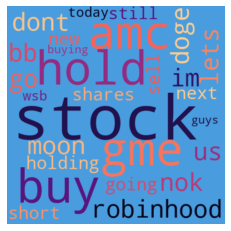

In [6]:
# Create and generate a word cloud image:
wordcloud = WordCloud(width=480, height=480, max_words = 30, background_color="rgb(73, 157, 222)",colormap="magma").generate(words)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
### Big movers: GME, NOK, AMC, Dogecoin ### 
### Other popular stocks: bitcoin, AMZN, MSFT, TSLA ###
### Also SMP 500 and stock indexes. ###

stonks = wallstreetbets[(wallstreetbets['title'] == 'gme') | (wallstreetbets['title'] == 'nok') | 
                       (wallstreetbets['title'] == 'amc') | (wallstreetbets['title'] == 'doge') | 
                       (wallstreetbets['title'] == 'btc') | (wallstreetbets['title'] == 'amzn') |
                       (wallstreetbets['title'] == 'msft')| (wallstreetbets['title'] == 'tsla') |
                       (wallstreetbets['title'] == 'sp500')].sort_values('count', ascending = True)

In [8]:
fig = px.bar(stonks, x='count', y='title', title='Mentions in WSB', 
             orientation = 'h', labels = {
                 'title': 'Securities',
                 'count': 'Number of Mentions'})

fig.update_traces(marker_color='rgb(73, 157, 222)',
                  marker_line_width=1.5)

fig.layout.plot_bgcolor='rgb(84, 85, 87)'

fig.layout.xaxis.gridcolor='rgb(144, 145, 142)'
fig.show()

In [9]:
### Organize by gme and date to graph ###
gme_date = wsb_full.groupby(['title','date']).count().reset_index()
gme_date = gme_date[gme_date['title'] == 'gme']

gme_date = gme_date.drop(['Unnamed: 0','author', 'scores',
                                     'comments', 'timestamp'], axis =1)
gme_date = gme_date.rename(columns = {'title':'title','date' : 'date', 'date_hour': 'count'})

In [63]:
fig = px.histogram(gme_date, x='date', y='count', title='Daily GME Mentions', nbins= len(gme_date['date']))

fig.layout.plot_bgcolor='rgb(84, 85, 87)'
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.xaxis.gridcolor='rgb(144, 145, 142)'
fig.update_traces(marker_color='rgb(73, 157, 222)',
                  marker_line_width=1.5)
fig.show()
fig.

In [11]:
### Group by gme and hour for graphing, reduce to Jan25-29th for easier graphing ###
jan_25 = datetime.strptime('2021-01-25 00:00:00', "%Y-%m-%d %H:%M:%S")
jan_29 = datetime.strptime('2021-01-29 23:00:00', "%Y-%m-%d %H:%M:%S")
gme_hour = wsb_full.groupby(['title','date_hour']).count().reset_index()
gme_hour = gme_hour[(gme_hour['title'] == 'gme') & (gme_hour['date_hour'] > jan_25)&
                    (gme_hour['date_hour'] <= jan_29)]
gme_hour = gme_hour.drop(['Unnamed: 0','author', 'scores',
                                     'comments', 'timestamp'], axis =1)
gme_hour = gme_hour.rename(columns = {'title':'title','date_hour' : 'date', 'date': 'count'})

In [12]:
fig = px.line(gme_hour, x='date', y='count', title='Hourly GME Mentions - Jan 25th to Jan 29th',
             labels = {
                 'date':'Hours',
                 'count':'Mentions'
             })
fig.update_traces(line_color='rgb(73, 157, 222)', line = {'width':3})
fig.layout.plot_bgcolor='rgb(84, 85, 87)'
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.xaxis.gridcolor='rgb(144, 145, 142)'
fig.show()

In [13]:
### Use alpha vantage to gather daily and hourly stock data ###

from alpha_vantage.timeseries import TimeSeries

API_key = 'OZHBQ2Q48QC0NFRZ'

### daily chart, include percent change ###
ts = TimeSeries(key = API_key,output_format='pandas')
data = ts.get_daily_adjusted('GME')
gme = data[0].reset_index()
gme_daily = gme[(gme['date'] >= '2020-12-31') & (gme['date'] <= '2021-02-16')]
gme_daily.to_csv('gme_daily_prices')
gme_daily=gme_daily.sort_values('date', ascending=True)
gme_daily['percent change'] = gme_daily['4. close'].pct_change()


### hourly chart, include percent change ###
data = ts.get_intraday('GME', interval = '60min', outputsize='full')
gme = data[0].reset_index()
gme_hourly_full = gme[(gme['date'] >= '2020-12-31') & (gme['date'] <= '2021-02-16')]
gme_hourly_full = gme_hourly_full.sort_values('date', ascending=True)
gme_hourly = gme[(gme['date'] >= '2021-01-25') & (gme['date'] <= '2021-01-29')]
gme_hourly = gme_hourly.sort_values('date', ascending=True)
gme_hourly['percent change'] = gme_hourly['4. close'].pct_change()
gme_hourly

,date,1. open,2. high,3. low,4. close,5. volume,percent change
351,2021-01-25 05:00:00,72.5000,136.6300,72.2000,105.39,1194735.0,NaN
350,2021-01-25 06:00:00,106.7700,109.0000,86.2500,96.77,885972.0,-0.081791
349,2021-01-25 07:00:00,96.9300,101.7000,90.3500,94.43,784325.0,-0.024181
348,2021-01-25 08:00:00,94.4800,97.0000,86.7200,91.65,2187519.0,-0.029440
347,2021-01-25 09:00:00,91.7100,104.5300,86.9999,98.05,4674120.0,0.069831
...,...,...,...,...,...,...,...
292,2021-01-28 16:00:00,246.1359,261.9899,197.4400,197.44,5687714.0,-0.201198
291,2021-01-28 17:00:00,197.4400,282.9200,193.6000,257.00,1543357.0,0.301661
290,2021-01-28 18:00:00,257.0000,509.0000,255.0000,281.85,418746.0,0.096693
289,2021-01-28 19:00:00,280.3300,348.8600,280.3300,347.01,1106541.0,0.231187


In [14]:
### Hourly candlestick graph ### 
fig = go.Figure(data=[go.Candlestick(x=gme_hourly_full['date'],
                open=gme_hourly_full['1. open'],
                high=gme_hourly_full['2. high'],
                low=gme_hourly_full['3. low'],
                close=gme_hourly_full['4. close'])])
fig.update_layout(
    title_text="Hourly Candlestick")

fig.update_yaxes(title_text="Price")
fig.update_xaxes(title_text="Date")

fig.layout.plot_bgcolor='rgb(84, 85, 87)'
fig.update_layout(xaxis_rangeslider_visible=False)
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.xaxis.gridcolor='rgb(144, 145, 142)'
fig.show()

In [15]:
### Daily candlestick graph ### 
fig = go.Figure(data=[go.Candlestick(x=gme_daily['date'],
                open=gme_daily['1. open'],
                high=gme_daily['2. high'],
                low=gme_daily['3. low'],
                close=gme_daily['4. close'])])

fig.update_layout(
    title_text="Daily Candlestick")

fig.update_yaxes(title_text="Price")
fig.update_xaxes(title_text="Date")
fig.layout.plot_bgcolor='rgb(84, 85, 87)'
fig.update_layout(xaxis_rangeslider_visible=False)
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.xaxis.gridcolor='rgb(144, 145, 142)'
fig.show()

In [16]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=gme_daily['date'], y=gme_daily['5. adjusted close'],
               name="Price"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter( x=gme_date['date'], y=gme_date['count'], name= 'Mentions'),
    secondary_y=True,
)
fig.update_layout(
    title_text="GME Price vs. Mentions"
)

fig.update_xaxes(title_text="Date")

fig.update_yaxes(title_text="Price", secondary_y=False)
fig.update_yaxes(title_text="Mentions", secondary_y=True)
fig.update_traces(line_color='rgb(255, 196, 0)', line = {'width':3}, secondary_y=False)
fig.update_traces(line_color='rgb(73, 157, 222)', line = {'width':3}, secondary_y=True)
fig.layout.plot_bgcolor='rgb(84, 85, 87)'
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.xaxis.gridcolor='rgb(144, 145, 142)'
fig.show()

In [46]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=gme_hourly['date'], y=gme_hourly['4. close'],
               name="Price"),
    secondary_y=False,)

fig.add_trace(
    go.Scatter( x=gme_hour['date'], y=gme_hour['count'], name= 'Mentions'),
    secondary_y=True,)
fig.update_layout(
    title_text="GME Hourly Price vs. Mentions")
fig.update_xaxes(title_text="Hour")
fig.update_yaxes(title_text="Price", secondary_y=False)
fig.update_yaxes(title_text="Mentions", secondary_y=True)

fig.update_traces(line_color='rgb(255, 196, 0)', line = {'width':3}, secondary_y=False)
fig.update_traces(line_color='rgb(73, 157, 222)', line = {'width':3}, secondary_y=True)
fig.layout.plot_bgcolor='rgb(84, 85, 87)'
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.xaxis.gridcolor='rgb(144, 145, 142)'

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0='2021-01-26 09:00:00', y0=115, x1='2021-01-26 11:00:00', y1=105,
    line_color="red",
)

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0='2021-01-27 19:00:00', y0=250, x1='2021-01-27 21:00:00', y1=230,
    line_color="red",
)

fig.add_shape(type="circle",
    xref="x", yref="y",
    x0='2021-01-29 09:00:00', y0=250, x1='2021-01-29 11:00:00', y1=270,
    line_color="red",
)
fig.show()
# fig.write_html('GME Hourly Prive vs Mentions.html')
# fig.write_image("GME Hourly Prive vs Mentions.png")

In [18]:
### Run hypothesis test. ###
### H0: The number of mentions of a stock on WSB in the first 1-1/2 hours of trading DOES NOT influence the stock growth ###
### H1: The number of mentions of a stock on WSB in the first 1-1/2 hours of trading DOES influence the stock growth ###
### Stock growth == open-close/open   of a trading day. ###
gme_hour_full = wsb_full.groupby(['title','date_hour']).count().reset_index()
gme_hour_full = gme_hour_full[(gme_hour_full['title'] == 'gme') & (gme_hour_full['date_hour'] > '2020-12-31 01:00:00')&
                    (gme_hour_full['date_hour'] <= '2021-02-16 23:00:00')]
gme_hour_full = gme_hour_full.drop(['Unnamed: 0','author', 'scores',
                                     'comments', 'timestamp'], axis =1)
gme_hour_full = gme_hour_full.rename(columns = {'title':'title','date_hour' : 'date', 'date': 'count'})


left = gme_hourly_full.set_index('date')
right = gme_hour_full.set_index('date')
gmefull=left.join(right).reset_index()
gmefull['count'] = gmefull['count'].fillna(0)
gmefull['percent change'] = (gmefull['4. close'] - gmefull['1. open'])/gmefull['1. open']
gmefull['time'] = gmefull['date'].apply(lambda x: datetime.time(x)).astype(str)
gmefull['day'] = gmefull['date'].apply(lambda x: datetime.date(x)).astype(str)

first_hours = gmefull[(gmefull['time'] == '08:00:00') | ((gmefull['time'] == '09:00:00'))]

first_hours = first_hours.groupby('day').sum()
first_hours = first_hours[['count']]


growth = gmefull.groupby('day').sum()[['percent change']]

growth_vs_hr = first_hours.join(growth)
sorted_corr = growth_vs_hr.sort_values('count')

In [52]:
### Details on Change of stock ###
gmefull['percent change'].describe()

count    472.000000
mean       0.004323
std        0.086254
min       -0.437637
25%       -0.018945
50%        0.000000
75%        0.015459
max        0.535226
Name: percent change, dtype: float64

In [53]:
### Details on Change of the stock ###
gmefull.groupby('day').sum().describe()['percent change']

count    30.000000
mean      0.068010
std       0.334279
min      -0.615414
25%      -0.051929
50%       0.032281
75%       0.232600
max       0.996509
Name: percent change, dtype: float64

In [54]:
fig = px.bar(gmefull, x='date', y="percent change", 
             title='Percent GME Change',
             labels = {
                 'date':'Date',
                 'count':'Percent Change'})
fig.update_traces(marker_color='rgb(73, 157, 222)',
                  marker_line_width=0)

fig.layout.plot_bgcolor='rgb(84, 85, 87)'
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.xaxis.gridcolor='rgb(144, 145, 142)'
fig.show()

In [57]:
stats.spearmanr(gmefull['count'],gmefull['percent change'])

SpearmanrResult(correlation=-0.10321609558737457, pvalue=0.02493075330552498)

In [ ]:
s_corr = stats.spearmanr(growth_vs_hr['count'], growth_vs_hr['percent change'])

In [22]:
s_corr = stats.spearmanr(growth_vs_hr['count'], growth_vs_hr['percent change'])
s_corr

SpearmanrResult(correlation=-0.0877017386768316, pvalue=0.6449129625582433)

In [49]:
# Graph with all data point. 
# H0 no correlation so Norm distibution around 0.
# Sample 
# close to open analysis. Mention after close
norm = stats.norm(0, 1).rvs(1000)
import plotly.express as px
df = px.data.tips()
fig = px.histogram(x=norm, histnorm='probability density')
fig.show()

In [41]:
growth_vs_hr['count percent'] = growth_vs_hr['count'] / growth_vs_hr['count'].max()
n = 1000
lst = []
for num in range(n):
    lst.append(np.random.choice(growth_vs_hr['count percent']))
lst

[0.004640371229698376,
 0.004640371229698376,
 0.01959267852539314,
 0.004640371229698376,
 0.007733952049497293,
 0.007733952049497293,
 0.004640371229698376,
 0.018561484918793503,
 0.001288992008249549,
 0.442897654034545,
 0.007733952049497293,
 0.442897654034545,
 0.0007733952049497294,
 0.004640371229698376,
 0.007733952049497293,
 0.0015467904098994587,
 0.026295436968290797,
 0.01959267852539314,
 0.010054137664346482,
 0.0634184068058778,
 0.0010311936065996391,
 0.0,
 1.0,
 0.0634184068058778,
 0.0015467904098994587,
 0.01263212168084558,
 0.009022944057746842,
 0.16189739623614333,
 0.001288992008249549,
 0.010054137664346482,
 0.442897654034545,
 0.34957463263727767,
 0.2552204176334107,
 0.001288992008249549,
 0.05955143078112916,
 0.018561484918793503,
 0.05955143078112916,
 1.0,
 0.0010311936065996391,
 0.010054137664346482,
 0.01263212168084558,
 0.0015467904098994587,
 0.16189739623614333,
 0.010054137664346482,
 0.01959267852539314,
 0.01959267852539314,
 0.1618973962

In [23]:
fig = go.Figure(data=go.Scatter(
    x=growth_vs_hr['count'],
    y=growth_vs_hr['percent change'],
    mode='markers',
    marker=dict(color='rgb(73, 157, 222)',
               )
))
fig.update_layout(
    title_text="Early Mentions vs. Daily Stock Change")
fig.update_xaxes(title_text="Mentions")
fig.update_yaxes(title_text="Growth")
fig.layout.plot_bgcolor='rgb(84, 85, 87)'
fig.layout.yaxis.gridcolor='rgb(144, 145, 142)'
fig.layout.xaxis.gridcolor='rgb(144, 145, 142)'
fig.show()
fig.write_html('Early Mentions vs Daily Stock Change.html')
fig.write_image("Early Mentions vs Daily Stock Change.png")

In [24]:
### I cannot reject the null hypothesis. ###
### The amount of mentions in the morning does not gave a positive or negative impact on the closing price of a stock###
### HO: The number of mentions in the last two hours of trading has no influence of opening prices. ###
### H1: The number of mentions in the last two hours of trading influences the opening price next day ###


last_hours = gmefull[(gmefull['time'] == '14:00:00') | ((gmefull['time'] == '16:00:00'))]
last_hours = last_hours.groupby('day').sum()
last_hours = last_hours[['count']]


gme_daily_shifted = gme_daily[['date' , '1. open', '4. close' ]]
gme_daily_shifted['4. close'] = gme_daily_shifted['4. close'].shift(periods = 1)
gme_daily_shifted['percent change'] = (gme_daily_shifted['1. open'] - gme_daily_shifted['4. close']) / gme_daily_shifted['4. close']
gme_daily_shifted = gme_daily_shifted.rename(columns = {'date':'day'}).astype(str).set_index('day')
gme_daily_joined = last_hours.join(gme_daily_shifted, how='left')


/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
s_corr2 = stats.spearmanr(gme_daily_joined['count'], gme_daily_joined['percent change'])
s_corr2

### THe p-value HEAVILY states that we cannot reject the null-hypothesis ### 

SpearmanrResult(correlation=-0.0035603027138667903, pvalue=0.9851027762191317)